# The downstream tracking study based on xgboost .
## Study dive into the model's prediction

The goal of this notebook is to get better understanding of each of the featrres, that were used in order to build the xgboost model. 


In [194]:
print ("kernel is alive!")

kernel is alive!


In [42]:
import pandas as pd
import numpy as np
import scipy as sp
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns

#sklearn imports 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold

# xgboost 
import xgboost as xgb
from xgboost import plot_importance

# sharp 
import shap


### As a very first step I need to grab training data form the NTpule. 
To obtain this goal I will use **root_numpy**, that allows me to convert root NTuple to pandas.Dataframe

In [4]:
train_data_file = "/data/work/mercury/Wessex/test/Brunel_BdJPsiKs_MagU_30k.csv"
data = pd.read_csv(train_data_file)
features = data.drop(["is_true_seed","has_MCParticle",
                      "is_downstream_reconstructible",
                      "has_MCParticle_not_electron",
                     "is_downstream_reconstructible_not_electron",
                     "seed_mva_value"] , axis=1).astype(np.float64)

target = data.is_downstream_reconstructible
features = features.drop(features.columns[0], axis=1)
features.head()

seed_chi2PerDoF        seed_p      seed_pt  seed_nLHCbIDs  seed_nbIT  \
0         1.447929   1849.101146  1083.522737           27.0        0.0   
1         0.354945  10085.622823  1345.148537           24.0        0.0   
2         2.906524   2441.534682  1013.888408           24.0        0.0   
3         3.234916   2604.073941   904.097232           24.0        0.0   
4         0.842265   2644.554049  1068.602364           23.0        0.0   

   seed_nLayers       seed_x      seed_y   seed_tx   seed_ty  
0          12.0 -1418.736880 -143.095899 -0.722093 -0.038671  
1          12.0  -393.699553 -284.193871 -0.129122 -0.037920  
2          12.0  -834.004914 -270.235334 -0.456235 -0.015198  
3          12.0  -475.119652 -230.380918 -0.369728 -0.018967  
4          12.0  -899.187260 -101.826800 -0.440227 -0.036610

### Print the features distributions

I want to know how doest the features looks like.

In [5]:
features.describe()

seed_chi2PerDoF        seed_p       seed_pt  seed_nLHCbIDs  \
count     2.415200e+06  2.415200e+06  2.415200e+06   2.415200e+06   
mean      1.871657e+00  2.138872e+04  1.730661e+03   1.792164e+01   
std       1.274678e+00  1.528150e+06  6.397556e+04   4.672918e+00   
min       1.030490e-03  1.121404e+03  2.736860e+00   8.000000e+00   
25%       9.834252e-01  3.318111e+03  9.752144e+02   1.300000e+01   
50%       1.494130e+00  6.400423e+03  1.153456e+03   1.900000e+01   
75%       2.391722e+00  1.445767e+04  1.406610e+03   2.200000e+01   
max       8.999642e+00  1.741231e+09  5.879921e+07   3.400000e+01   

          seed_nbIT  seed_nLayers        seed_x        seed_y       seed_tx  \
count  2.415200e+06  2.415200e+06  2.415200e+06  2.415200e+06  2.415200e+06   
mean   2.797962e+00  1.125978e+01  4.302253e-01 -4.526582e+00 -2.401685e-03   
std    4.762586e+00  1.028624e+00  7.095528e+02  5.222606e+02  3.068898e-01   
min    0.000000e+00  8.000000e+00 -2.536045e+03 -2.368444e+03 -1.303497e+00   
25%    0.000000e+00  1.100000e+01 -3.969852e+02 -2.058561e+02 -1.735886e-01   
50%    0.000000e+00  1.200000e+01  9.255241e-01 -3.572218e+00 -3.683508e-03   
75%    4.000000e+00  1.200000e+01  4.014095e+02  1.991543e+02  1.691624e-01   
max    2.300000e+01  1.200000e+01  2.511015e+03  2.224234e+03  1.307487e+00   

            seed_ty  
count  2.415200e+06  
mean  -5.792746e-04  
std    6.750835e-02  
min   -4.931323e-01  
25%   -2.951513e-02  
50%   -2.420115e-04  
75%    2.868205e-02  
max    4.260690e-01

In [235]:
def print_features_histograms(features, target):
    hist_params = {'normed': True, 'bins': 60, 'alpha': 0.4}
    # create the figure
    fig = plt.figure(figsize=(16,  25))
    for n, feature in enumerate(features):
        # add sub plot on our figure
        ax = fig.add_subplot(features.shape[1] // 2, 2, n + 1)
        # define range for histograms by cutting 1% of data from both ends
        min_value, max_value = np.percentile(features[feature], [1, 99])
        min_value-=0.1*max_value
        max_value+=0.2*max_value
        ax.hist(features.ix[target == 0, feature].values, range=(min_value, max_value), 
                 label='ghost', **hist_params)
        ax.hist(features.ix[target == 1, feature].values, range=(min_value, max_value), 
                 label='true', **hist_params)
        ax.legend(loc='best')

        ax.set_title(feature)

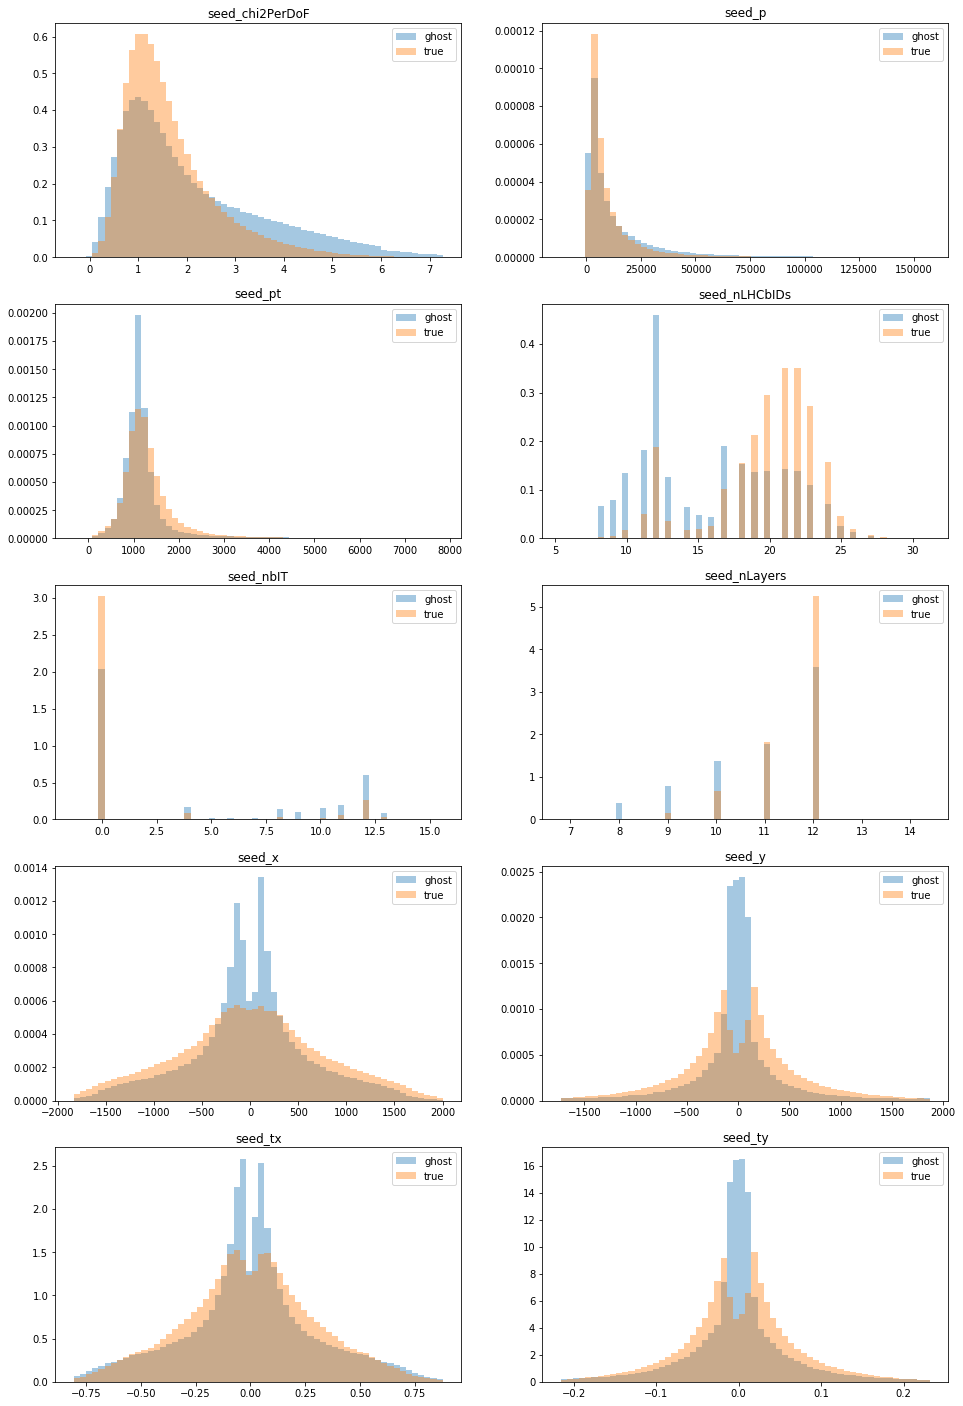

In [236]:
print_features_histograms(features, target)

# Feature Engenering

## Add transformated features

At the begining let's try some very basic feature transformation. 
I also add pseudorapidity and seed_r

In [6]:
def basic_transforamtion(data):
    #abs transformation
    out = data
    out["abs_seed_x"]=np.abs(data['seed_x'])
    out["abs_seed_y"]=np.abs(data['seed_y'])
    out["abs_seed_tx"]=np.abs(data['seed_tx'])
    out["abs_seed_ty"]=np.abs(data['seed_ty'])
    out['seed_r'] = np.sqrt(np.square(data.seed_x) +np.square(data.seed_y))    
    out['pseudo_rapidity'] = np.arctanh(data.seed_pt/data.seed_p)
    return out

In [7]:
new_data = basic_transforamtion(data)
new_features =  new_data.drop(["is_true_seed","has_MCParticle",
                    "is_downstream_reconstructible",
                    "has_MCParticle_not_electron",
                    "is_downstream_reconstructible_not_electron",
                    "seed_mva_value",
                    "seed_x",
                    "seed_y",
                    "seed_tx",
                    "seed_ty",
                    "Unnamed: 0"          ] , axis=1).astype(np.float64)

new_features.head()

seed_chi2PerDoF        seed_p      seed_pt  seed_nLHCbIDs  seed_nbIT  \
0         1.447929   1849.101146  1083.522737           27.0        0.0   
1         0.354945  10085.622823  1345.148537           24.0        0.0   
2         2.906524   2441.534682  1013.888408           24.0        0.0   
3         3.234916   2604.073941   904.097232           24.0        0.0   
4         0.842265   2644.554049  1068.602364           23.0        0.0   

   seed_nLayers   abs_seed_x  abs_seed_y  abs_seed_tx  abs_seed_ty  \
0          12.0  1418.736880  143.095899     0.722093     0.038671   
1          12.0   393.699553  284.193871     0.129122     0.037920   
2          12.0   834.004914  270.235334     0.456235     0.015198   
3          12.0   475.119652  230.380918     0.369728     0.018967   
4          12.0   899.187260  101.826800     0.440227     0.036610   

        seed_r  pseudo_rapidity  
0  1425.935051         0.671511  
1   485.556891         0.134172  
2   876.693408         0.441959  
3   528.028457         0.362240  
4   904.934487         0.428511

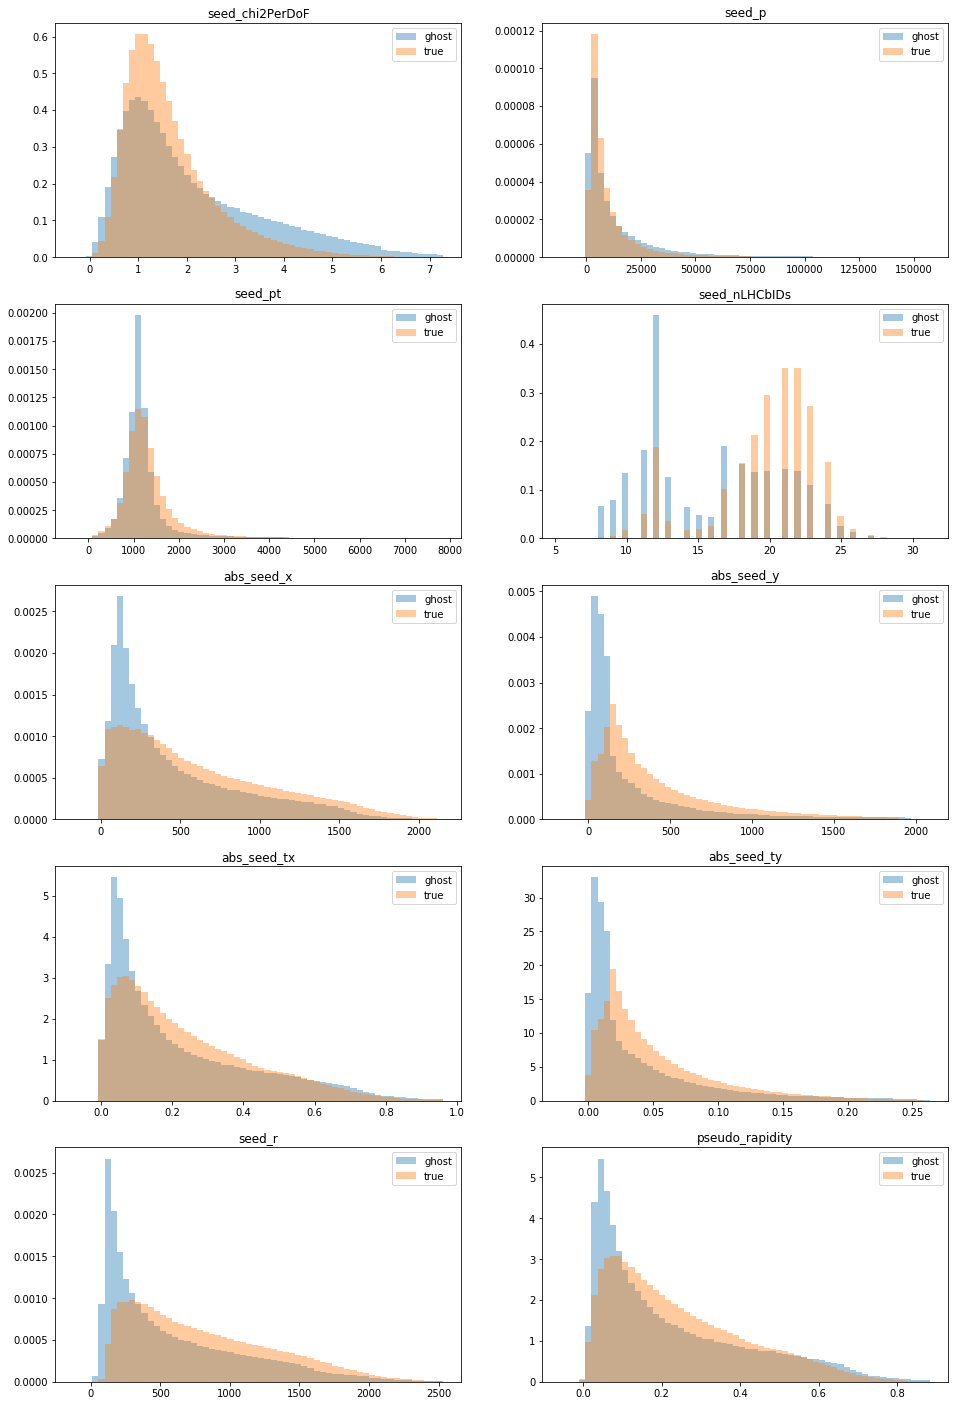

In [305]:
features_to_print = new_features[["seed_chi2PerDoF","seed_p",
                                "seed_pt",
                                "seed_nLHCbIDs",
                                "abs_seed_x",
                                "abs_seed_y",
                                "abs_seed_tx",
                                "abs_seed_ty",
                                "seed_r",
                                "pseudo_rapidity"]]
print_features_histograms(features_to_print, target)

# Explanation based on Shapley value

In [196]:
new_trainX, new_testX, new_trainY, new_testY = train_test_split(new_features, target, random_state=42,train_size=0.9 )

new_trainX =  new_trainX.as_matrix()
new_testX = new_testX.as_matrix()

eval_set= [(new_trainX,new_trainY), (new_testX, new_testY)]
evals_result = {}
eval_metric=["error", "logloss", "auc"]

gb =xgb.XGBClassifier(n_estimators=300, learning_rate=0.049915496699718766, max_depth=11,
                 max_features= 0.3777993838461427,min_child_weight= 5,subsample= 0.4442307520949027, 
                    objective="gpu:binary:logistic", tree_method="gpu_exact",predictor='gpu_predictor',
                       silent=False, verbose_eval=True, eval_metric=eval_metric, evals_result=evals_result)
gb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, eval_metric=['error', 'logloss', 'auc'],
              evals_result={}, gamma=0, learning_rate=0.049915496699718766,
              max_delta_step=0, max_depth=11, max_features=0.3777993838461427,
              min_child_weight=5, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='gpu:binary:logistic',
              predictor='gpu_predictor', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=False,
              subsample=0.4442307520949027, tree_method='gpu_exact',
              verbose_eval=True)

In [197]:
%%time
gb.fit(new_trainX,new_trainY, eval_set=eval_set)

[0]	validation_0-error:0.146004	validation_0-logloss:0.665767	validation_0-auc:0.911521	validation_1-error:0.150807	validation_1-logloss:0.666072	validation_1-auc:0.908163
[1]	validation_0-error:0.139676	validation_0-logloss:0.640887	validation_0-auc:0.920305	validation_1-error:0.1447	validation_1-logloss:0.641483	validation_1-auc:0.917146
[2]	validation_0-error:0.140486	validation_0-logloss:0.61833	validation_0-auc:0.921835	validation_1-error:0.145537	validation_1-logloss:0.619192	validation_1-auc:0.918633
[3]	validation_0-error:0.13757	validation_0-logloss:0.597498	validation_0-auc:0.923754	validation_1-error:0.142584	validation_1-logloss:0.59868	validation_1-auc:0.920279
[4]	validation_0-error:0.137964	validation_0-logloss:0.578451	validation_0-auc:0.924257	validation_1-error:0.142932	validation_1-logloss:0.5799	validation_1-auc:0.920827
[5]	validation_0-error:0.13654	validation_0-logloss:0.560765	validation_0-auc:0.925596	validation_1-error:0.141827	validation_1-logloss:0.562509	va

[48]	validation_0-error:0.120047	validation_0-logloss:0.317364	validation_0-auc:0.941484	validation_1-error:0.127141	validation_1-logloss:0.326944	validation_1-auc:0.936875
[49]	validation_0-error:0.11987	validation_0-logloss:0.31608	validation_0-auc:0.941612	validation_1-error:0.126975	validation_1-logloss:0.325782	validation_1-auc:0.936983
[50]	validation_0-error:0.119738	validation_0-logloss:0.314768	validation_0-auc:0.941757	validation_1-error:0.126834	validation_1-logloss:0.324615	validation_1-auc:0.937096
[51]	validation_0-error:0.119457	validation_0-logloss:0.313392	validation_0-auc:0.94197	validation_1-error:0.126557	validation_1-logloss:0.323375	validation_1-auc:0.937285
[52]	validation_0-error:0.119226	validation_0-logloss:0.312125	validation_0-auc:0.942142	validation_1-error:0.126482	validation_1-logloss:0.322227	validation_1-auc:0.937446
[53]	validation_0-error:0.119023	validation_0-logloss:0.310997	validation_0-auc:0.942286	validation_1-error:0.126255	validation_1-logloss:

[96]	validation_0-error:0.112123	validation_0-logloss:0.28316	validation_0-auc:0.947902	validation_1-error:0.120516	validation_1-logloss:0.298471	validation_1-auc:0.941915
[97]	validation_0-error:0.112009	validation_0-logloss:0.282777	validation_0-auc:0.948012	validation_1-error:0.12035	validation_1-logloss:0.298173	validation_1-auc:0.942008
[98]	validation_0-error:0.111808	validation_0-logloss:0.282304	validation_0-auc:0.948148	validation_1-error:0.120247	validation_1-logloss:0.297862	validation_1-auc:0.9421
[99]	validation_0-error:0.111735	validation_0-logloss:0.282033	validation_0-auc:0.948222	validation_1-error:0.120238	validation_1-logloss:0.297689	validation_1-auc:0.942139
[100]	validation_0-error:0.111627	validation_0-logloss:0.281715	validation_0-auc:0.948308	validation_1-error:0.120139	validation_1-logloss:0.297468	validation_1-auc:0.942207
[101]	validation_0-error:0.111535	validation_0-logloss:0.281481	validation_0-auc:0.948358	validation_1-error:0.120023	validation_1-logloss

[144]	validation_0-error:0.109245	validation_0-logloss:0.274763	validation_0-auc:0.950257	validation_1-error:0.11833	validation_1-logloss:0.292764	validation_1-auc:0.943576
[145]	validation_0-error:0.109238	validation_0-logloss:0.274735	validation_0-auc:0.950264	validation_1-error:0.118342	validation_1-logloss:0.292753	validation_1-auc:0.943578
[146]	validation_0-error:0.109155	validation_0-logloss:0.274505	validation_0-auc:0.950347	validation_1-error:0.118268	validation_1-logloss:0.292592	validation_1-auc:0.943641
[147]	validation_0-error:0.109162	validation_0-logloss:0.274476	validation_0-auc:0.950353	validation_1-error:0.118255	validation_1-logloss:0.292572	validation_1-auc:0.943645
[148]	validation_0-error:0.109063	validation_0-logloss:0.274276	validation_0-auc:0.95042	validation_1-error:0.118255	validation_1-logloss:0.292471	validation_1-auc:0.943679
[149]	validation_0-error:0.108987	validation_0-logloss:0.274079	validation_0-auc:0.950484	validation_1-error:0.118197	validation_1-l

[192]	validation_0-error:0.106867	validation_0-logloss:0.26894	validation_0-auc:0.95222	validation_1-error:0.116897	validation_1-logloss:0.289521	validation_1-auc:0.944701
[193]	validation_0-error:0.106797	validation_0-logloss:0.268811	validation_0-auc:0.952265	validation_1-error:0.116823	validation_1-logloss:0.289447	validation_1-auc:0.94473
[194]	validation_0-error:0.106683	validation_0-logloss:0.268557	validation_0-auc:0.952359	validation_1-error:0.116798	validation_1-logloss:0.289286	validation_1-auc:0.94479
[195]	validation_0-error:0.106578	validation_0-logloss:0.268326	validation_0-auc:0.952443	validation_1-error:0.116727	validation_1-logloss:0.289187	validation_1-auc:0.944824
[196]	validation_0-error:0.106504	validation_0-logloss:0.268146	validation_0-auc:0.952504	validation_1-error:0.116657	validation_1-logloss:0.289119	validation_1-auc:0.944849
[197]	validation_0-error:0.106488	validation_0-logloss:0.268078	validation_0-auc:0.952526	validation_1-error:0.116636	validation_1-log

[240]	validation_0-error:0.104339	validation_0-logloss:0.263446	validation_0-auc:0.95418	validation_1-error:0.115456	validation_1-logloss:0.286558	validation_1-auc:0.945801
[241]	validation_0-error:0.104335	validation_0-logloss:0.263423	validation_0-auc:0.954188	validation_1-error:0.11544	validation_1-logloss:0.286549	validation_1-auc:0.945804
[242]	validation_0-error:0.104325	validation_0-logloss:0.263398	validation_0-auc:0.954195	validation_1-error:0.11544	validation_1-logloss:0.286541	validation_1-auc:0.945808
[243]	validation_0-error:0.104318	validation_0-logloss:0.263392	validation_0-auc:0.954198	validation_1-error:0.115444	validation_1-logloss:0.286538	validation_1-auc:0.945809
[244]	validation_0-error:0.104301	validation_0-logloss:0.263338	validation_0-auc:0.954215	validation_1-error:0.115431	validation_1-logloss:0.286515	validation_1-auc:0.945819
[245]	validation_0-error:0.104293	validation_0-logloss:0.263327	validation_0-auc:0.954219	validation_1-error:0.115423	validation_1-lo

[288]	validation_0-error:0.102804	validation_0-logloss:0.259909	validation_0-auc:0.955439	validation_1-error:0.114533	validation_1-logloss:0.284853	validation_1-auc:0.946419
[289]	validation_0-error:0.102782	validation_0-logloss:0.259832	validation_0-auc:0.955471	validation_1-error:0.114533	validation_1-logloss:0.284833	validation_1-auc:0.946428
[290]	validation_0-error:0.102781	validation_0-logloss:0.259823	validation_0-auc:0.955475	validation_1-error:0.114533	validation_1-logloss:0.284832	validation_1-auc:0.946429
[291]	validation_0-error:0.102773	validation_0-logloss:0.259792	validation_0-auc:0.955484	validation_1-error:0.114541	validation_1-logloss:0.28482	validation_1-auc:0.946433
[292]	validation_0-error:0.102769	validation_0-logloss:0.259788	validation_0-auc:0.955485	validation_1-error:0.114541	validation_1-logloss:0.284822	validation_1-auc:0.946432
[293]	validation_0-error:0.10265	validation_0-logloss:0.259567	validation_0-auc:0.955564	validation_1-error:0.114475	validation_1-l

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, eval_metric=['error', 'logloss', 'auc'],
              evals_result={}, gamma=0, learning_rate=0.049915496699718766,
              max_delta_step=0, max_depth=11, max_features=0.3777993838461427,
              min_child_weight=5, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='gpu:binary:logistic',
              predictor='gpu_predictor', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=False,
              subsample=0.4442307520949027, tree_method='gpu_exact',
              verbose_eval=True)

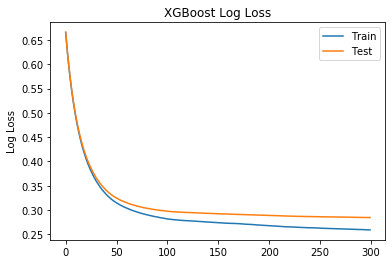

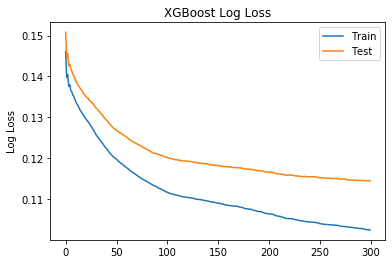

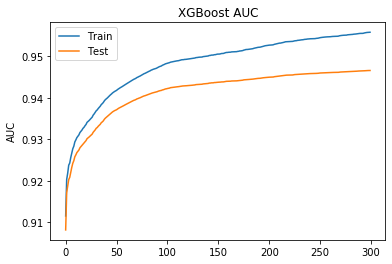

In [199]:
results = gb.evals_result()
epochs = len(results['validation_0']["error"])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']["logloss"], label='Train')
ax.plot(x_axis, results['validation_1']["logloss"], label='Test')

ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']["error"], label='Train')
ax.plot(x_axis, results['validation_1']["error"], label='Test')

ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']["auc"], label='Train')
ax.plot(x_axis, results['validation_1']["auc"], label='Test')


ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

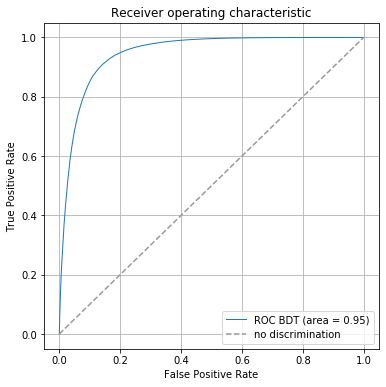

In [200]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(new_testY, gb.predict_proba(new_testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

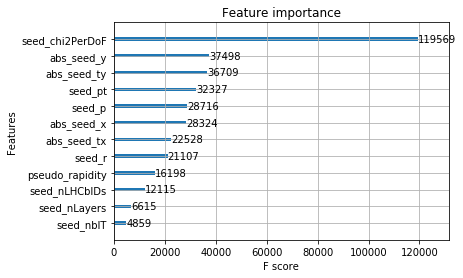

In [46]:
plot_importance(gb);

In [201]:
def plot_features_importance(model):
    # create the figure
    fig = plt.figure(figsize=(16,  25))
    importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']

    for n, importance_type in enumerate(importance_types):
        # add sub plot on our figure
        ax = fig.add_subplot(len(importance_types) // 2+1, 2, n + 1)
        feature_important = gb.get_booster().get_score(importance_type=importance_type)
        keys = list(feature_important.keys())
        values = list(feature_important.values())

        column_name = "score: " + importance_type 
        data = pd.DataFrame(data=values, index=keys, columns=[column_name]).sort_values(by = column_name)
        data.plot(kind='barh', ax=ax);
        plt.xlabel("F score")
        ax.legend()

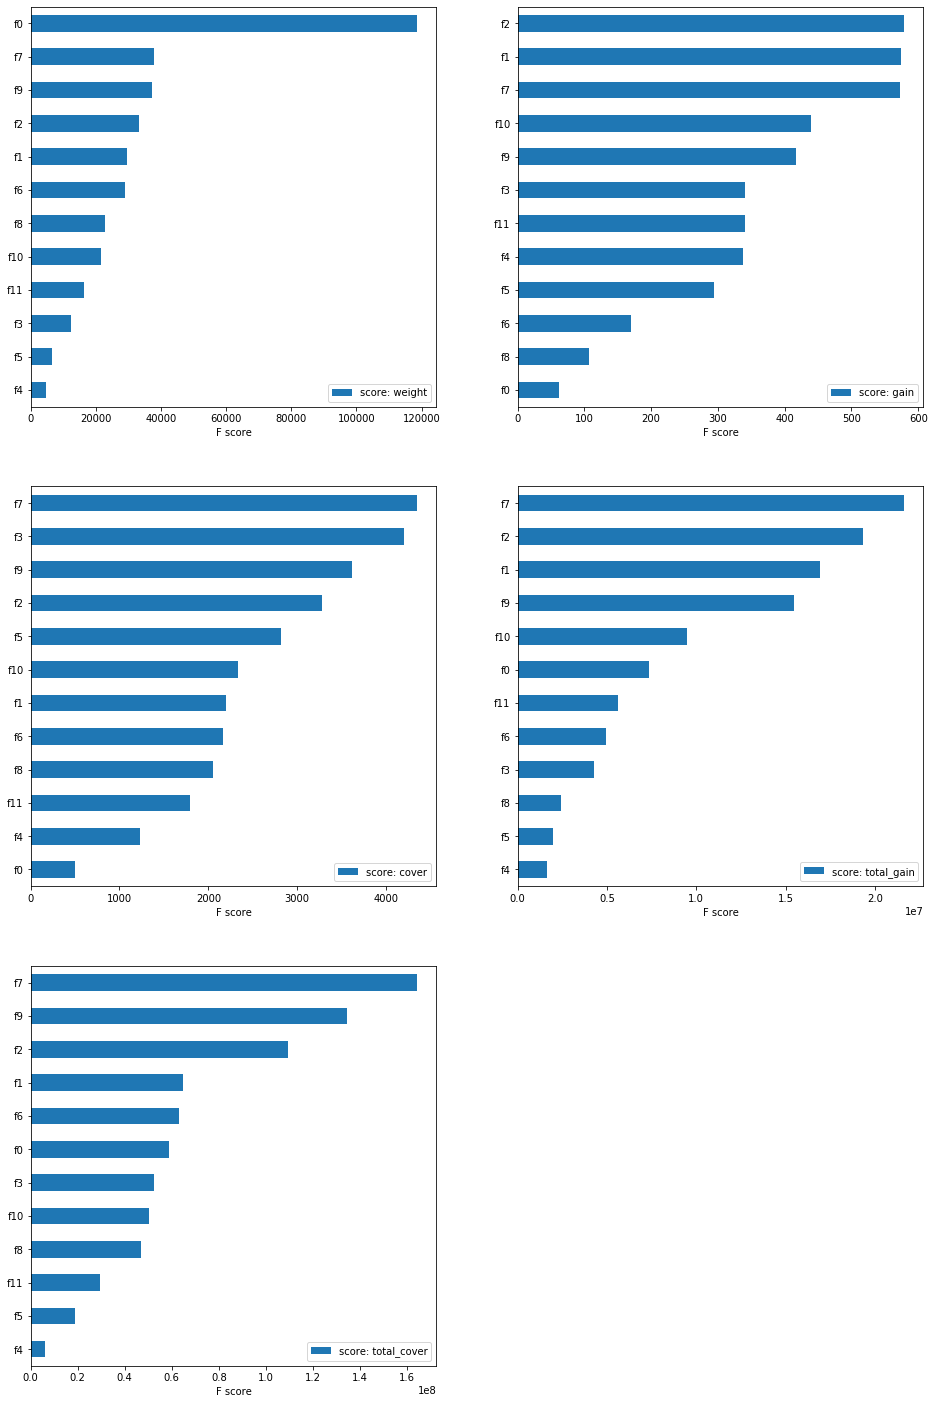

In [202]:
plot_features_importance(gb)

In [13]:
explainer = shap.TreeExplainer(gb)

In [17]:
shap_values = explainer.shap_values(new_testX[:5000] )

In [ ]:
shap_values_2 = explainer.shap_values(new_testX[:50000] )


In [20]:
import dill
dill.dump_session('xgboost_exp.db')


In [43]:
dill.load_session("xgboost_exp.db")

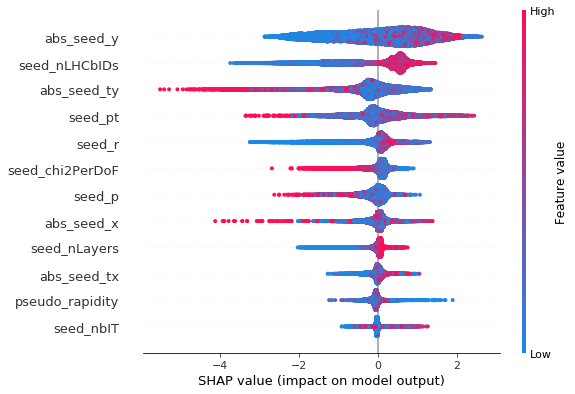

In [30]:
shap.summary_plot(shap_values_2, new_testX[:50000])


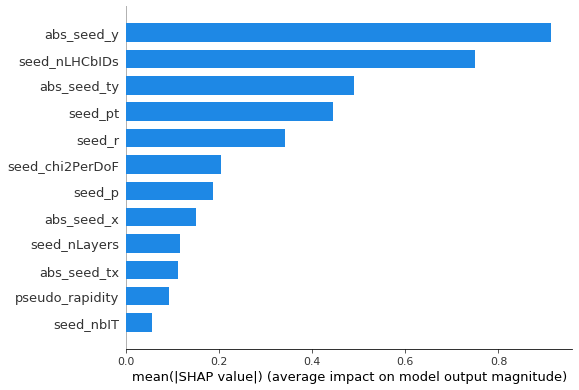

In [33]:
shap.summary_plot(shap_values_2, new_testX[:50000], plot_type="bar")


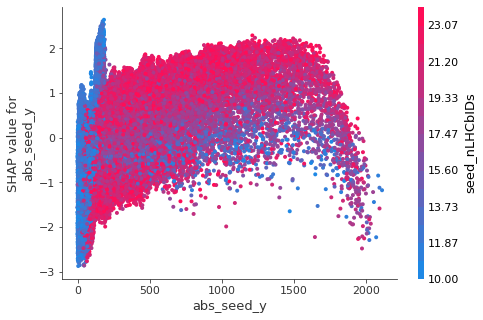

In [39]:
shap.dependence_plot("abs_seed_y", shap_values_2, new_testX[:50000] )

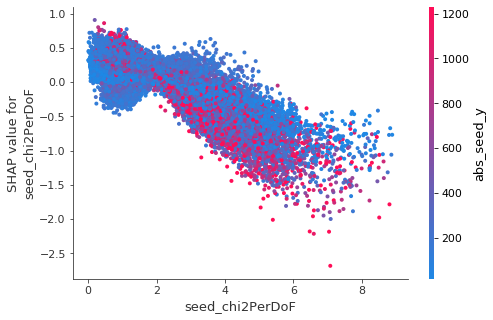

In [40]:
shap.dependence_plot("seed_chi2PerDoF", shap_values_2, new_testX[:50000] )

In [94]:
def plot_features_shapley_values(shapley_val, features):
    fig = plt.figure(figsize=(16,  25))
    for n, feature in enumerate(features):
        # add sub plot on our figure
        #ax = fig.add_subplot(len(features) // 2+1, 2, n + 1)
        shap.dependence_plot(feature, shap_values_2, new_testX[:50000] )

In [95]:
new_testX.columns.to_list()

['seed_chi2PerDoF',
 'seed_p',
 'seed_pt',
 'seed_nLHCbIDs',
 'seed_nbIT',
 'seed_nLayers',
 'abs_seed_x',
 'abs_seed_y',
 'abs_seed_tx',
 'abs_seed_ty',
 'seed_r',
 'pseudo_rapidity']

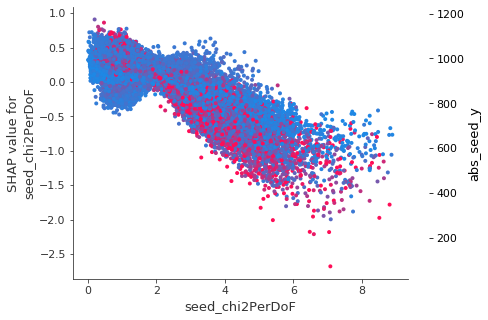

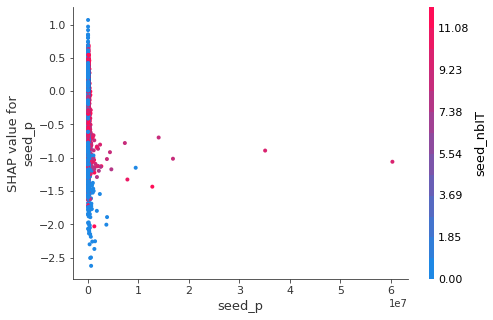

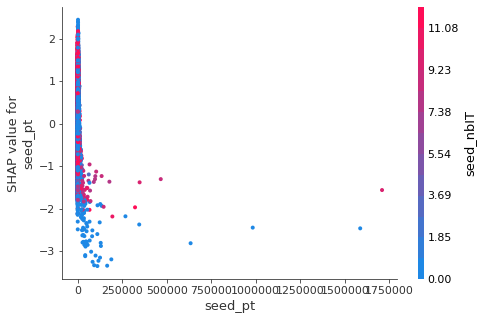

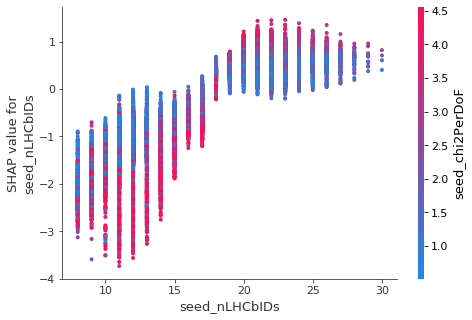

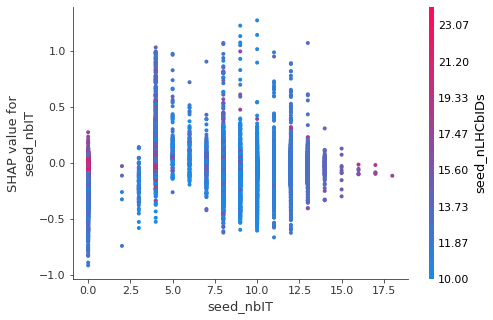

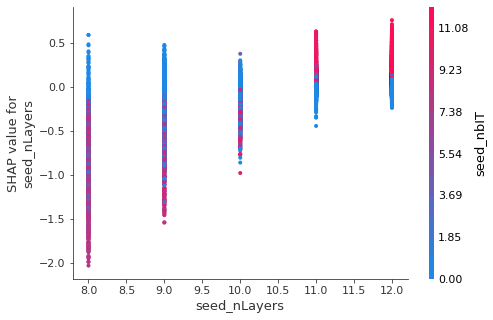

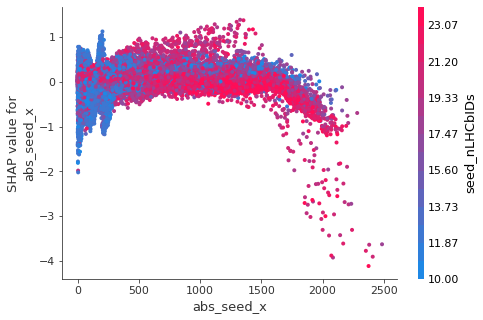

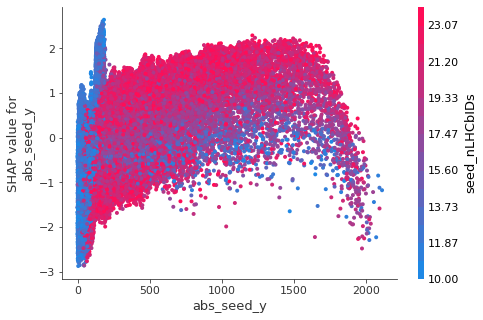

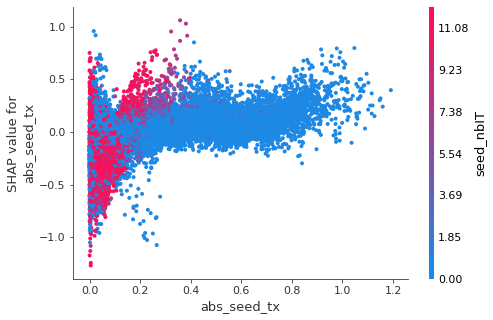

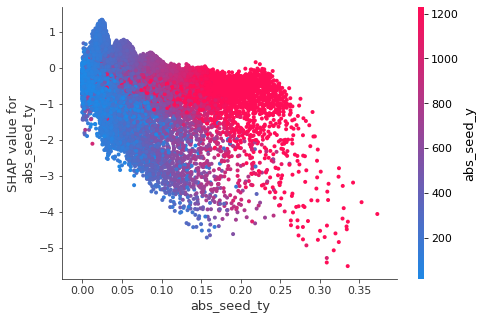

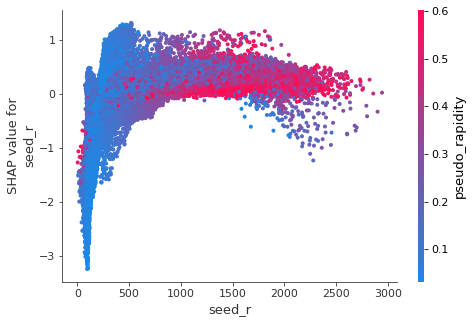

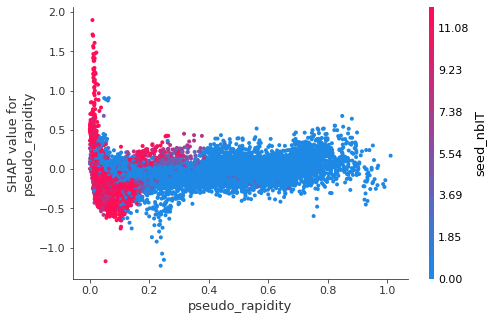

In [96]:
plot_features_shapley_values(shap_values_2, new_testX.columns.to_list())

## Explanation of the model via lime package

In this apprach the package explains the model on a single prediction level. 
It is looking into point clostest neighbourhood and approximetes the prediction using logistic regression. 

In [203]:
import sys
!{sys.executable} -m pip install lime


In [204]:
import lime
import lime.lime_tabular

array(['seed_chi2PerDoF', 'seed_p', 'seed_pt', 'seed_nLHCbIDs',
       'seed_nbIT', 'seed_nLayers', 'abs_seed_x', 'abs_seed_y',
       'abs_seed_tx', 'abs_seed_ty', 'seed_r', 'pseudo_rapidity'],
      dtype=object)

In [278]:
new_features.columns.values

array(['seed_chi2PerDoF', 'seed_p', 'seed_pt', 'seed_nLHCbIDs',
       'seed_nbIT', 'seed_nLayers', 'abs_seed_x', 'abs_seed_y',
       'abs_seed_tx', 'abs_seed_ty', 'seed_r', 'pseudo_rapidity'],
      dtype=object)

In [281]:
features_names = new_features.columns.values.tolist()

features_names[0]="$Seed_\chi^2$"
features_names

['$Seed_\\chi^2$',
 'seed_p',
 'seed_pt',
 'seed_nLHCbIDs',
 'seed_nbIT',
 'seed_nLayers',
 'abs_seed_x',
 'abs_seed_y',
 'abs_seed_tx',
 'abs_seed_ty',
 'seed_r',
 'pseudo_rapidity']

In [282]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(new_trainX, class_names=["Ghost","True"],
                                                        feature_names=features_names, discretize_continuous=True)

In [315]:
i = np.random.randint(0, new_testX.shape[0])

exp = lime_explainer.explain_instance(new_testX[i], gb.predict_proba, num_features=12)

In [316]:
new_testY.iloc[[i]]

2177253    True
Name: is_downstream_reconstructible, dtype: bool

In [318]:
exp.show_in_notebook(show_table=False, show_all=False)

In [302]:
i2 = np.random.randint(0, new_testX.shape[0])

exp = lime_explainer.explain_instance(new_testX[i2], gb.predict_proba, num_features=10)
exp

In [303]:
new_testY.iloc[[i2]]

241932    False
Name: is_downstream_reconstructible, dtype: bool

In [304]:
exp.show_in_notebook(show_table=False, show_all=False)